# **Customer Segmentation Using RFM Analysis**

## Import Libraries

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


## Load Data

In [2]:
df = pd.read_csv("Online_retail.csv")
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
df.shape

(1067371, 8)

In [4]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [ ]:
#drop na values
df.dropna(subset=['Customer ID'],inplace=True)

In [ ]:
#Apply to_datetime to format the date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [7]:
df['TotalAmount'] = df['Quantity'] * df['Price']

In [8]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [9]:
reference_date = df["InvoiceDate"].max()

In [10]:
reference_date

Timestamp('2011-12-09 12:50:00')

In [ ]:
#Groupby CustomerID with InvoiceDate,Invoice and Total Amount to create a new dataset rfm
rfm = df.groupby("Customer ID").agg({
    'InvoiceDate': lambda x:(reference_date-x.max()).days,
    'Invoice' : 'count',
    'TotalAmount' : 'sum'
})

In [ ]:
#rename the columns
rfm.rename(columns={'InvoiceDate': 'Recency', 'Invoice': 'Frequency', 'TotalAmount': 'Monetary'}, inplace=True)

In [13]:
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,325,48,-64.68
12347.0,1,253,5633.32
12348.0,74,51,2019.40
12349.0,18,180,4404.54
12350.0,309,17,334.40


In [14]:
quantiles = rfm.quantile(q=[0.25, 0.5, 0.75])

# Assign RFM scores
def RScore(x, p, d):
    if p == 'Recency':
        if x <= d[p][0.25]:
            return 4
        elif x <= d[p][0.50]:
            return 3
        elif x <= d[p][0.75]:
            return 2
        else:
            return 1
    else:
        if x <= d[p][0.25]:
            return 1
        elif x <= d[p][0.50]:
            return 2
        elif x <= d[p][0.75]:
            return 3
        else:
            return 4

rfm['R'] = rfm['Recency'].apply(RScore, args=('Recency', quantiles,))
rfm['F'] = rfm['Frequency'].apply(RScore, args=('Frequency', quantiles,))
rfm['M'] = rfm['Monetary'].apply(RScore, args=('Monetary', quantiles,))


In [15]:
rfm.head()

,Recency,Frequency,Monetary,R,F,M
Customer ID,,,,,,
12346.0,325,48,-64.68,2,2,1
12347.0,1,253,5633.32,4,4,4
12348.0,74,51,2019.40,3,2,3
12349.0,18,180,4404.54,4,4,4
12350.0,309,17,334.40,2,1,2


In [ ]:
#Create Segment and score columns
rfm['RFM_Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
rfm['RFM_Score'] = rfm['R']+rfm['F']+rfm['M']

In [17]:
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
Customer ID,,,,,,,,
12346.0,325,48,-64.68,2,2,1,221,5
12347.0,1,253,5633.32,4,4,4,444,12
12348.0,74,51,2019.40,3,2,3,323,8
12349.0,18,180,4404.54,4,4,4,444,12
12350.0,309,17,334.40,2,1,2,212,5


In [ ]:
#Create segments of customers on the basis of scores
def segment_by_score(score):
    if score >= 9:
        return 'Champions'
    elif score >= 7:
        return 'Loyal Customers'
    elif score >= 5:
        return 'Potential Loyalist'
    elif score >= 3:
        return 'Needs Attention'
    else:
        return 'At Risk'

rfm['Customer_Segment'] = rfm['RFM_Score'].apply(segment_by_score)


In [19]:
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,Customer_Segment
Customer ID,,,,,,,,,
12346.0,325,48,-64.68,2,2,1,221,5,Potential Loyalist
12347.0,1,253,5633.32,4,4,4,444,12,Champions
12348.0,74,51,2019.40,3,2,3,323,8,Loyal Customers
12349.0,18,180,4404.54,4,4,4,444,12,Champions
12350.0,309,17,334.40,2,1,2,212,5,Potential Loyalist


## Marketing Ideas for Different Customer Segments

### 1. Champions (your best, most loyal customers)

* Exclusive discounts or early access to new products.

* VIP clubs (special badges, premium support, birthday gifts).

* Encourage referrals (give them perks for bringing friends).

* Feature them in case studies/testimonials.

### 2. Loyal Customers (consistent buyers, not top tier yet)

*  Create a loyalty program with points/rewards.

* Bundle offers or “buy more, save more” deals.

* Ask for reviews/feedback in exchange for small perks.

* Send personalized recommendations.

### 3. Potential Loyalists (new but frequent buyers)

* Offer welcome discounts after 2–3 purchases.

* Send thank-you emails with product suggestions.

* Onboarding campaigns to nurture them into champions.

* Surprise freebies on next order.

### 4. New Customers

* First purchase discount or coupon for next order.

* Onboarding emails introducing brand values, products, how to use items.

* Short “How-to” guides or tutorials to increase product adoption.

* Encourage social media engagement (“Share your first purchase with us”).

### 5. At Risk Customers (haven’t purchased in a while)

* Re-engagement campaigns: “We miss you” emails with discounts.

* Personalized win back offers based on past purchases.

* Limited time deals to create urgency.

* Send new product updates that fit their profile.

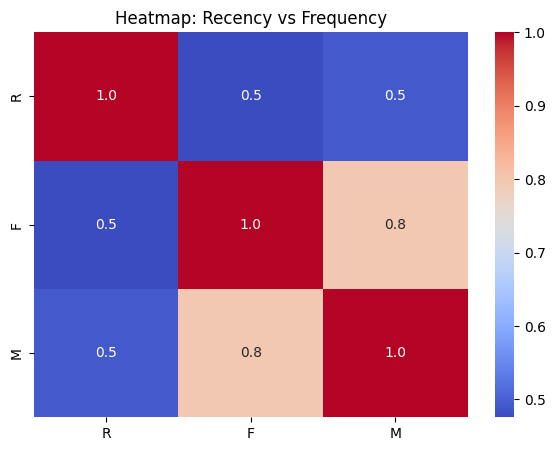

In [23]:
data = rfm[['R','F','M']]
corr = data.corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, fmt='.1f', cmap='coolwarm')
plt.title('Heatmap: Recency vs Frequency')
#plt.xlabel('Frequency Score')
#plt.ylabel('Recency Score')
plt.show()

### Insights:
  * Frequency and Monetary have a strong positive correlation.
  * Recency and Frequency have a moderate positive correlation.
  * Recency and Monetary value are moderately correlated.
   

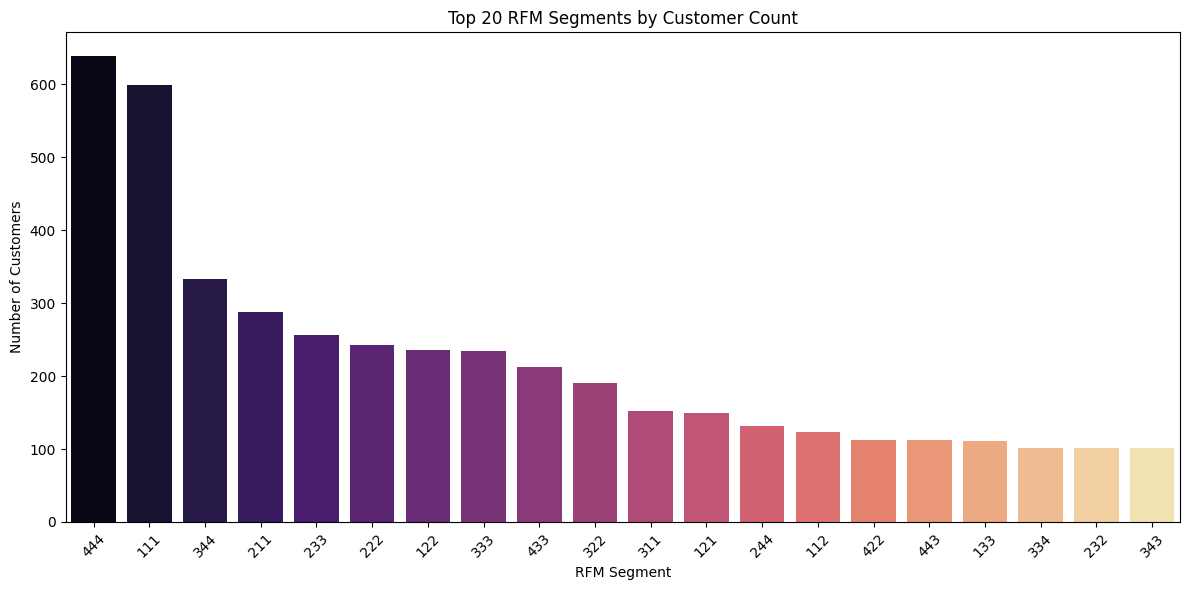

In [21]:
segment_counts = rfm['RFM_Segment'].value_counts().reset_index()
segment_counts.columns = ['RFM_Segment', 'CustomerCount']


plt.figure(figsize=(12, 6))
sns.barplot(data=segment_counts.head(20), x='RFM_Segment', y='CustomerCount', palette='magma',hue='RFM_Segment',legend=False)
plt.title('Top 20 RFM Segments by Customer Count')
plt.xlabel('RFM Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Insights:
* 44 (Best Customers): They buy often, spend a lot, and purchased recently → keep them loyal with rewards.

* 111 (Lost Customers): They haven’t bought in a long time, spend little, and rarely buy → either re-engage or let go.

* Middle groups (222, 233, 322, etc.): They’re average customers → can be pushed to become loyal buyers with the right offers.

* New/Promising (244, 122, 133): Recently bought but not frequent yet → nurture them so they stick around.

In [ ]:
# We can save the rfm file using to_csv method
data = rfm.to_csv('rfm_analysis.csv', index=False)